In [1]:
import pandas as pd
import numpy as np

import cupy

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

### CSV

In [2]:
bank_train_csv = "data/processed/bank_train.csv"
bank_test_csv = "data/processed/bank_test.csv"
bank_val_csv = "data/processed/bank_val.csv"

labels_train = "data/processed/bank_train_labels.csv"
labels_test = "data/processed/bank_test_labels.csv"
labels_val = "data/processed/bank_val_labels.csv"

### Labels

In [3]:
labels_train_data = pd.read_csv(labels_train)
labels_train_data.drop(labels_train_data.columns[0], axis=1, inplace=True)

labels_test_data = pd.read_csv(labels_test)
labels_test_data.drop(labels_test_data.columns[0], axis=1, inplace=True)

labels_val_data = pd.read_csv(labels_val)
labels_val_data.drop(labels_val_data.columns[0], axis=1, inplace=True)

### Features

In [4]:
bank_train_data = pd.read_csv(bank_train_csv)
bank_test_data = pd.read_csv(bank_test_csv)
bank_val_data = pd.read_csv(bank_val_csv)

bank_train_data.drop(bank_train_data.columns[0], axis=1, inplace=True)
bank_test_data.drop(bank_test_data.columns[0], axis=1, inplace=True)
bank_val_data.drop(bank_val_data.columns[0], axis=1, inplace=True)

#### Combining test and validation data

In [5]:
x_test = pd.concat([bank_test_data, bank_val_data], ignore_index=True)
y_test = pd.concat([labels_test_data, labels_val_data], ignore_index=True)

### XGBoost Classifier

In [6]:
# Train a model using the scikit-learn API
classifier = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic',
                                   tree_method='hist', eta=0.1, max_depth=3, enable_categorical=True, device='cuda')
classifier.fit(cupy.array(bank_train_data), labels_train_data)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [7]:
# dtrain_clf = xgb.DMatrix(bank_train_data, labels_train_data['target'].values, enable_categorical=True, device='cuda')
# dtest_clf = xgb.DMatrix(x_test, y_test['target'].values, enable_categorical=True)

In [8]:
# params = {"objective": "binary:hinge", "tree_method": "hist", "device" : "cuda", "num_class": 2}
# n = 1000

# results = xgb.cv(
#    params, dtrain_clf,
#    num_boost_round=n,
#    nfold=5,
#    metrics=["mlogloss", "auc", "merror"],
# )

In [14]:
y_pred = classifier.predict(cupy.array(x_test))

probabilities = classifier.predict_proba(x_test)

### Custom Threshold

In [15]:
positive_prob = probabilities[:,1]

threshold = 0.2

custom_predictions = (positive_prob > threshold).astype(int)

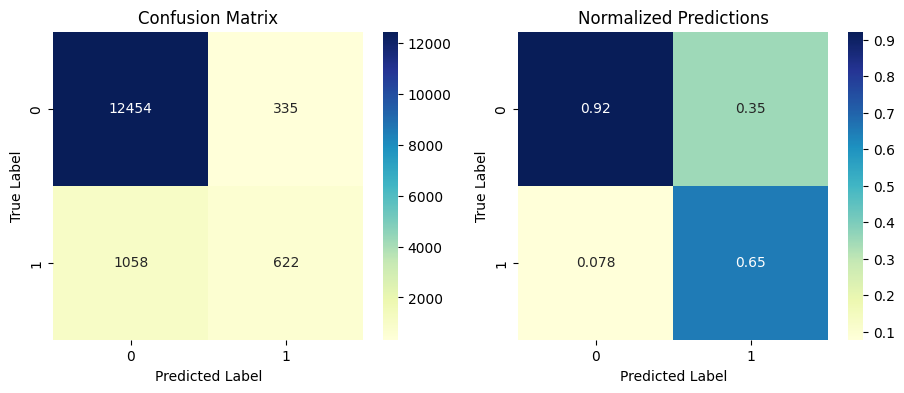

In [16]:
confusionMatrix = confusion_matrix(y_test, y_pred)
confusionMatrixNorm = confusion_matrix(y_test, y_pred, normalize='pred')

fig, axes = plt.subplots(1,2, figsize=(11,4))

sns.heatmap(confusionMatrix, annot=True, ax=axes[0], cmap='YlGnBu', fmt="d")
axes[0].set_title("Confusion Matrix")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

sns.heatmap(confusionMatrixNorm, annot=True, cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Normalized Predictions")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

plt.show()

### Classification Report

In [17]:
target_names = ['Unsuccessful', 'Successful']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Unsuccessful       0.92      0.97      0.95     12789
  Successful       0.65      0.37      0.47      1680

    accuracy                           0.90     14469
   macro avg       0.79      0.67      0.71     14469
weighted avg       0.89      0.90      0.89     14469



### ROC Curve

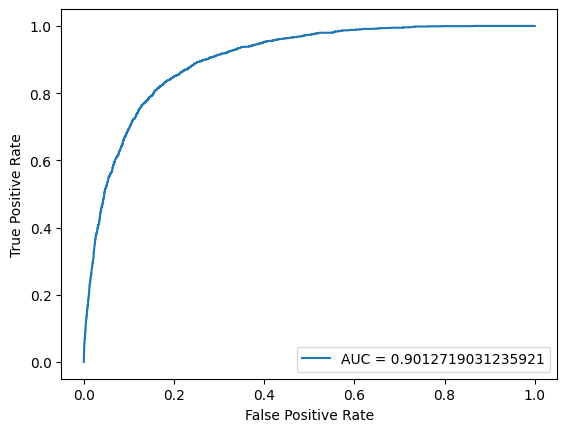

In [18]:
y_pred_proba = classifier.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()